Библиотеки

In [27]:
import os
import typing as tp
from itertools import product
import warnings

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import cv2
import tifffile as tiff

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Пути и прочие константы

In [2]:
IMG_PATH = '/home/jupyter-igor_busov/Seed/Hyperspectral/data/session_000/'
PROJECT_PATH = '/home/jupyter-igor_busov/Seed'
CALIBR_WHITE_PATH = '/home/jupyter-igor_busov/Seed/Hyperspectral/data/calibr/session_000_024_snapshot_cube.tiff'
CALIBR_BLACK_CAP_PATH = '/home/jupyter-igor_busov/Seed/Hyperspectral/data/calibr/session_000_025_snapshot_cube.tiff'
CALIBR_BLACK_BACKGROUND_PATH = '/home/jupyter-igor_busov/Seed/Hyperspectral/data/calibr/session_000_026_snapshot_cube.tiff'
PURPLE_IMG = '/home/jupyter-igor_busov/Seed/Hyperspectral/data/session_000/session_000_046_snapshot_cube.tiff'

$\textbf{Код}$

класс, описывающий гиперспектральное изображение с основными используемыми в этой работе методами 

In [3]:
class Hyper_Img:
    """
    Hyperspectral image with basic methods
    """
    
    def __init__(self, path: str, threshold_value: float = 25, 
                 savgol_par: tp.Tuple[int] = (9, 3)) -> None:
        self.savgol_par = savgol_par
        self._threshold_value = threshold_value
        self.path = path
        self.img = self._get_tiff()
        self.widht = self.img.shape[0]
        self.height = self.img.shape[1]
        self.mutation = self._get_mutation()
        self.pixels =  self._get_pixels()
        self.medians = self._get_medians()
    
    @staticmethod
    def wave_len(x: int, step: int = 4, begin_wave_len: int = 450) -> int:
        return int((x - begin_wave_len) // step)
    
    def _get_tiff(self) -> None:
        img = tiff.imread(self.path)
        bl_img = tiff.imread(CALIBR_BLACK_BACKGROUND_PATH)
        new_img = np.where(bl_img > img, 0, img - bl_img)
        wh_img = tiff.imread(CALIBR_WHITE_PATH)
        return new_img /(wh_img - bl_img)
    
    def _get_mutation(self) -> str:
        if not set(IMG_PATH.split('/')).issubset(set(self.path.split('.')[0].split('/'))):
            raise NameError('Error in path')
        
        number = int(self.path.split('/')[-1].split('.')[0].split('_')[2])
        
        if number < 25 and number > 0:
            return '-4'  
        elif number > 24 and number < 27:
            return '-1' 
        elif number > 26 and number < 41:
            return 'wt' 
        elif number > 40 and number < 45:
            return '-1'
        elif number == 45:
            return 'light'
        elif number == 46:
            return 'purple'
        elif number == 47:
            return 'blue'
        else:
            return 'control'
        
    def _get_pixels(self) -> tp.List[tp.Tuple[int, int]]:
        return [(x, y) for x, y in product(range(self.widht), range(self.height)) 
                if self.threshold_bgr[x,y] != 0]
    
    def _get_medians(self) -> np.array:
        medians: tp.List[float] = list()
        for i in range(self.img.shape[2]):
            medians.append(np.median(np.array([self.img[p[0]][p[1]][i] for p in self.pixels])))
        return savgol_filter(np.array(medians), *self.savgol_par)
    
    def is_purple(self) -> bool:
        return self.path == PURPLE_IMG
 
    @property
    def bgr(self) -> np.array:
        
        #To accurately display colors, you need to choose constants
        
        im_r = self.img[:,:,Hyper_Img.wave_len(630)]
        im_g = self.img[:,:,Hyper_Img.wave_len(510)]
        im_b = self.img[:,:,Hyper_Img.wave_len(450)]
    
        im_r = (im_r / im_r.max())*255
        im_g = (im_g / im_g.max())*255
        im_b = (im_b / im_b.max())*255
    
        im_r = np.clip(im_r,0,255).astype(np.uint8)
        im_g = np.clip(im_g,0,255).astype(np.uint8)
        im_b = np.clip(im_b,0,255).astype(np.uint8)
    
        im_bgr = np.zeros((self.widht, self.height, 3), dtype = np.uint8)
        im_bgr[:,:,0] = im_b
        im_bgr[:,:,1] = im_g
        im_bgr[:,:,2] = im_r
    
        return im_bgr
    
    @property
    def threshold_bgr(self) -> np.array:
        im_black = cv2.cvtColor(self.bgr, cv2.COLOR_BGR2GRAY)
        _, im_thr = cv2.threshold(im_black, self._threshold_value, 255, cv2.THRESH_BINARY)
        return im_thr
    
    def __repr__(self) -> str:
        fig, axes = plt.subplots(1, 2)
        
        axes[0].imshow(self.bgr, cmap = 'gray')
        axes[0].set_title('rgb visualization')
        
        axes[1].imshow(self.threshold_bgr, cmap = 'gray')
        axes[1].set_title('segmentation')
        
        return f'mutation: {self.mutation}'
     

Примеры изображений (визуализация не точно передает цвета)

mutation: purple

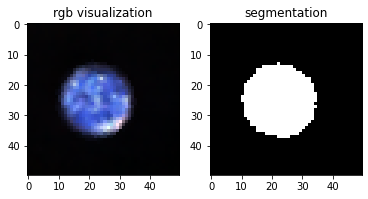

In [4]:
Hyper_Img(IMG_PATH + 'session_000_046_snapshot_cube.tiff')

mutation: light

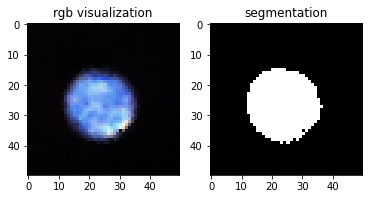

In [5]:
Hyper_Img(IMG_PATH + 'session_000_045_snapshot_cube.tiff')

mutation: blue

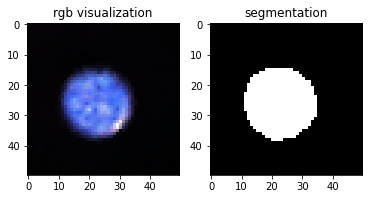

In [6]:
Hyper_Img(IMG_PATH + 'session_000_047_cube.tiff')

mutation: -4

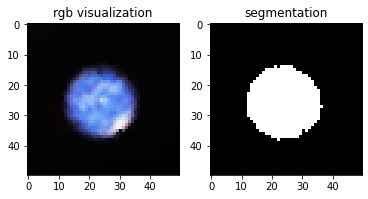

In [7]:
Hyper_Img(IMG_PATH + 'session_000_017_snapshot_cube.tiff')

mutation: -1

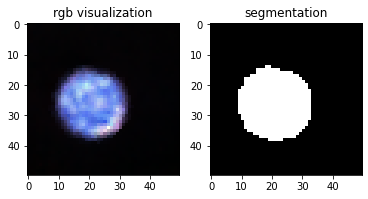

In [8]:
Hyper_Img(IMG_PATH + 'session_000_025_snapshot_cube.tiff')

mutation: wt

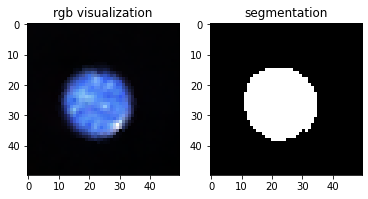

In [9]:
Hyper_Img(IMG_PATH + 'session_000_027_snapshot_cube.tiff')

Функция, возвращающая необходимые имена в директории

In [10]:
def all_tiff_cube_img(path: str) -> tp.List[str]:
    img_names: tp.List[str] = list()
    for dirname, _, filenames in os.walk(path):
        for filename in filenames: 
            name = os.path.join(filename)
            if name.split('.')[-1] != 'tiff':
                continue
            if name.split('.')[0].split('_')[-1] != 'cube':
                continue
            img_names.append(dirname + '/' + name)
            
    return img_names 

считываем все необходимые изображения 

In [11]:
#hyper_imgs - list with all hyperspectral images
hyper_imgs: tp.List[Hyper_Img] = [Hyper_Img(name) for name in all_tiff_cube_img(IMG_PATH)
                                  if Hyper_Img(name).mutation != 'control']    

$\textbf{Графики медиан для каждого канала}$

In [12]:
def get_all_medians(hyper_imgs: tp.List[Hyper_Img], with_purple: bool = True) -> pd.DataFrame:
    """
    create DataFrame for graphics
    """
    
    x_axis: tp.List[int] = list(np.arange(0,138)*4 + 450)
    points: tp.List[tp.Tuple[float, float, int, str]] = list()
    if not with_purple:
        pur_img = Hyper_Img(PURPLE_IMG)
    
    for sample_number, sample in enumerate(hyper_imgs):
        
        if sample.path == PURPLE_IMG and not with_purple:
            continue
        
        if sample.mutation == 'control':
            continue
        
        if with_purple:
            point = zip(x_axis, sample.medians)
        else:
            point = zip(x_axis, sample.medians - pur_img.medians)
        
        for p in point:
            points.append([p[0], p[1], sample_number, sample.mutation])
        

    return pd.DataFrame(points, columns = ['Wavelength', 'Median', 'Sample', 'Mutation'])      

In [13]:
df_all_med = get_all_medians(hyper_imgs)
df_all_med.sample(7)

,Wavelength,Median,Sample,Mutation
5880,786,0.471714,42,-4
5815,526,0.429056,42,-4
2899,454,0.227745,21,wt
1497,918,0.316765,10,blue
2047,910,0.345228,14,-4
4338,690,0.827963,31,-4
3202,562,0.736979,23,-4


<AxesSubplot:xlabel='Wavelength', ylabel='Median'>

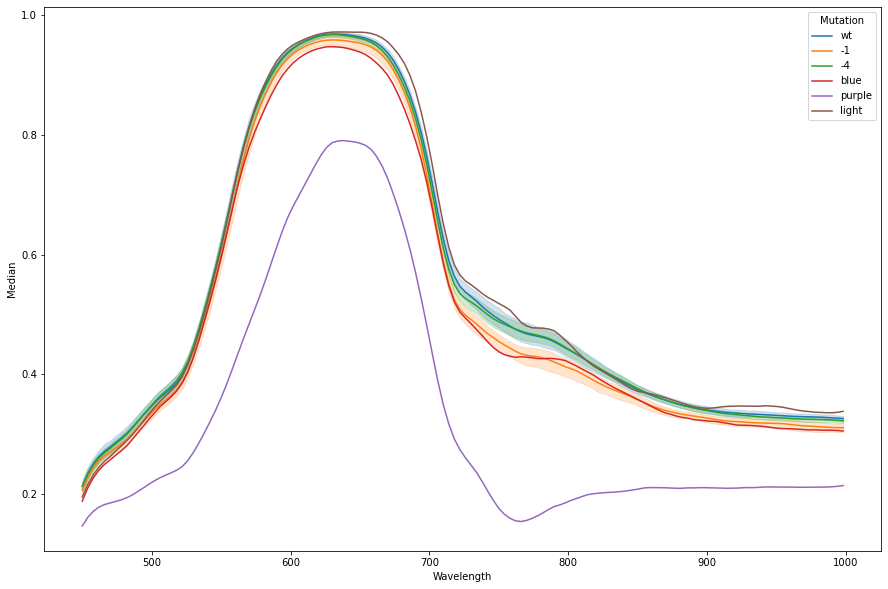

In [14]:
plt.figure(figsize=(15,10))
sns.lineplot(data=df_all_med, x='Wavelength', y='Median', hue='Mutation')

$\textbf{Графики медиан для каждого канала с вычетем вектора медиан фиолетовых зерен}$

In [15]:
df_med_without_pur = get_all_medians(hyper_imgs, with_purple = False)
df_med_without_pur.sample(7)

,Wavelength,Median,Sample,Mutation
2168,842,0.167543,15,-4
2853,822,0.203333,20,-4
4404,954,0.109080,31,-4
6092,530,0.167171,44,-1
4526,890,0.119944,32,-1
1400,530,0.158746,10,blue
2571,798,0.255949,18,wt


<AxesSubplot:xlabel='Wavelength', ylabel='Median'>

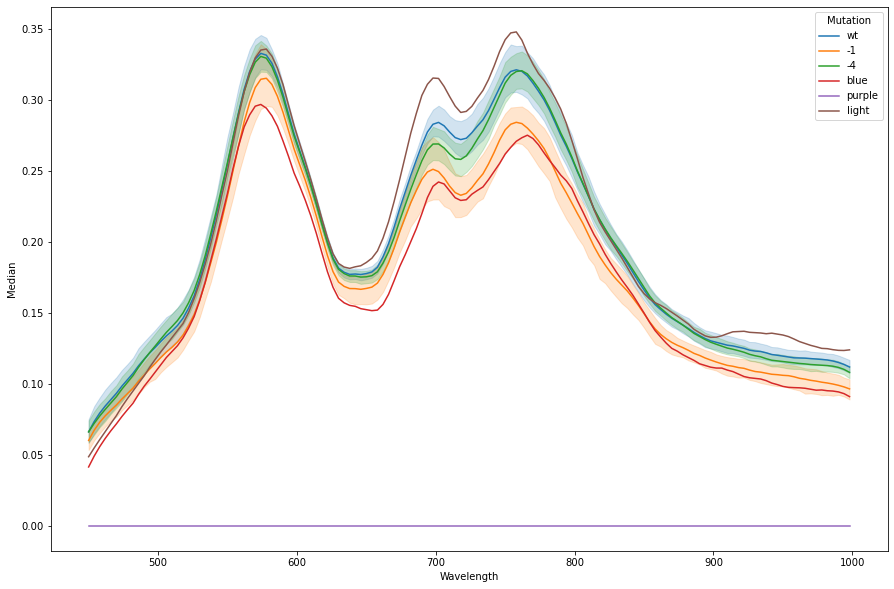

In [16]:
plt.figure(figsize=(15,10))
sns.lineplot(data=df_med_without_pur, x='Wavelength', y='Median', hue='Mutation')

$\textbf{PCA}$

In [17]:
#Пайплайн
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=5))])

In [18]:
def get_med_df(hyper_imgs: tp.List[Hyper_Img]) -> pd.DataFrame:
    """
    create DataFrame for PCA
    """
        
    return pd.DataFrame([list(sample.medians) + [sample.mutation] for sample in hyper_imgs 
                         if sample.mutation != 'control'], 
                        columns = list(np.arange(0,138)*4 + 450) + ['Mutation'])    

In [19]:
df = get_med_df(hyper_imgs)
df.sample(7)

,450,454,458,462,466,470,474,478,482,486,...,966,970,974,978,982,986,990,994,998,Mutation
24,0.210912,0.231691,0.247442,0.259309,0.268438,0.276063,0.284232,0.291854,0.299987,0.310555,...,0.330779,0.330229,0.329715,0.329487,0.329785,0.329467,0.329167,0.328998,0.329074,-4
7,0.188663,0.209796,0.225453,0.236954,0.245618,0.252801,0.260815,0.269408,0.278551,0.289045,...,0.328931,0.328785,0.329632,0.330672,0.331046,0.331329,0.330973,0.329715,0.327292,-4
21,0.204604,0.227745,0.245074,0.257845,0.267309,0.274719,0.282414,0.288881,0.297375,0.307587,...,0.327591,0.328379,0.328660,0.328589,0.327921,0.327399,0.327161,0.327435,0.328448,wt
37,0.249486,0.267735,0.281838,0.292811,0.301670,0.309213,0.318483,0.327042,0.336203,0.347657,...,0.352442,0.352569,0.353186,0.353137,0.352680,0.351480,0.349477,0.346548,0.342568,-4
25,0.232483,0.251165,0.265019,0.275302,0.283272,0.290140,0.298973,0.307331,0.316496,0.327636,...,0.318979,0.317546,0.316846,0.315876,0.315152,0.314891,0.314640,0.314225,0.313475,-4
12,0.244501,0.270247,0.288796,0.301817,0.310983,0.318238,0.326033,0.333229,0.341023,0.351728,...,0.344701,0.343808,0.343280,0.343114,0.343571,0.344153,0.344612,0.344706,0.344197,wt
17,0.192956,0.213262,0.228345,0.239353,0.247434,0.253610,0.260157,0.266459,0.274116,0.283788,...,0.318166,0.316955,0.316475,0.315681,0.315249,0.314551,0.314040,0.313856,0.314140,wt


In [20]:
X = df.drop(['Mutation'], axis = 1)
X.head()

,450,454,458,462,466,470,474,478,482,486,...,962,966,970,974,978,982,986,990,994,998
0,0.201098,0.224436,0.241224,0.252910,0.260943,0.266593,0.273272,0.279074,0.286476,0.296511,...,0.324540,0.325866,0.327065,0.327589,0.327369,0.326985,0.326024,0.325664,0.326490,0.329083
1,0.215291,0.238958,0.255781,0.267444,0.275630,0.282693,0.289970,0.296837,0.304894,0.314864,...,0.330701,0.329790,0.329089,0.329287,0.328262,0.327760,0.326710,0.325630,0.324672,0.323992
2,0.198189,0.219666,0.235404,0.246689,0.254810,0.260687,0.268024,0.274328,0.281879,0.291820,...,0.306309,0.305212,0.304417,0.304087,0.304450,0.304355,0.304299,0.304359,0.304597,0.305074
3,0.242184,0.261785,0.276793,0.288289,0.297354,0.305078,0.313921,0.321413,0.329904,0.340151,...,0.320716,0.320294,0.320215,0.320538,0.319978,0.320691,0.320933,0.321451,0.322407,0.323962
4,0.194874,0.216189,0.231607,0.242487,0.250188,0.256197,0.262750,0.269070,0.275919,0.284405,...,0.297055,0.296313,0.295738,0.295189,0.295036,0.295405,0.295792,0.296058,0.296033,0.295548


In [21]:
y = df[['Mutation']]
y.head()

,Mutation
0,wt
1,-1
2,-1
3,-4
4,-1


обучение и процент дисперсии для каждой компаненты

In [22]:
X = pipe.fit_transform(X)
pipe['pca'].explained_variance_ratio_

array([0.89790041, 0.05583149, 0.01847964, 0.01099158, 0.00560734])

визуализация

In [23]:
warnings.simplefilter('ignore')
new_arr = np.array(tuple(zip(X[:,:2], y['Mutation'])))
lst_of_value = [(new_arr[i][0][0], new_arr[i][0][1], new_arr[i][1]) for i, _ in enumerate(new_arr)]
pd.DataFrame(lst_of_value, columns = ['1', '2', 'Mutation']).sample(7)

,1,2,Mutation
12,-12.128974,4.074368,wt
31,2.188090,-0.755530,-4
22,64.445502,4.651863,purple
41,-14.471192,2.083233,-4
45,-3.162979,-2.572075,-4
21,-1.124800,-1.007081,wt
35,-7.584051,4.541866,-4


<AxesSubplot:xlabel='1', ylabel='2'>

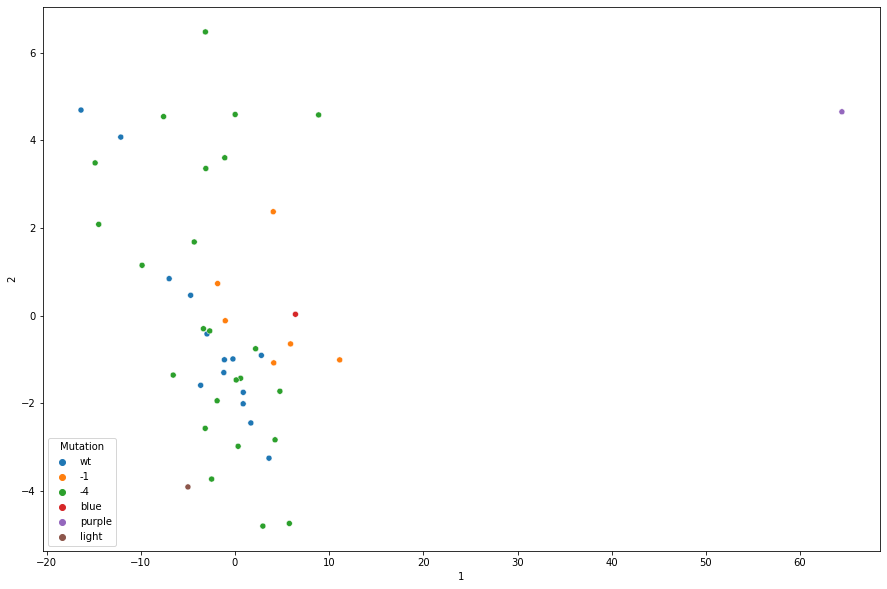

In [24]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=pd.DataFrame(lst_of_value, 
                                  columns=['1', '2', 'Mutation']), x='1', y='2', hue='Mutation')

In [25]:
new_arr = np.array(tuple(zip(X[:,:2], y['Mutation'])))
lst_of_value = [(new_arr[i][0][0], new_arr[i][0][1], new_arr[i][1]) for i, _ in enumerate(new_arr) 
                if new_arr[i][1] != 'purple']
pd.DataFrame(lst_of_value, columns = ['1', '2', 'Mutation']).sample(7)

,1,2,Mutation
2,5.897181,-0.644995,-1
16,0.877117,-1.750107,wt
37,-4.996828,-3.908299,light
0,2.798446,-0.906457,wt
14,-9.866224,1.148794,-4
26,4.767758,-1.725123,-4
34,-7.584051,4.541866,-4


визуализация без фиолетовых зерен

<AxesSubplot:xlabel='1', ylabel='2'>

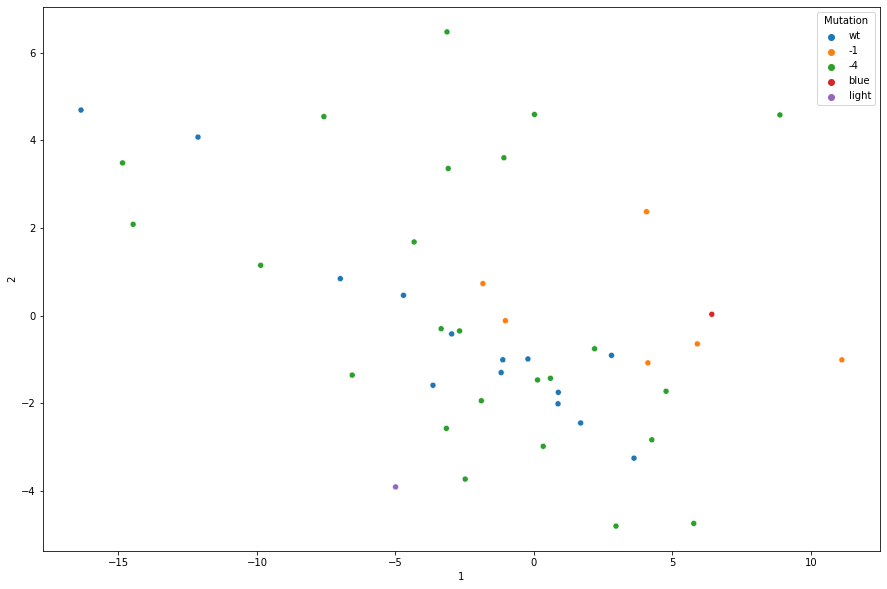

In [26]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=pd.DataFrame(lst_of_value, 
                                  columns=['1', '2', 'Mutation']), x='1', y='2', hue='Mutation')